<a href="https://colab.research.google.com/github/liirusuk/llm_train/blob/main/Week_3_homework_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1. Predicting loan approval

In this task you will practice working with features and linear models on the [loan approval dataset from Kaggle](https://www.kaggle.com/datasets/lorenzozoppelletto/financial-risk-for-loan-approval). You can either download it from Kaggle, or from github (coming soon), or use the google drive download link below.

In [ ]:
!gdown 1kPOSKkArR8TwHf_nGyvAJh2TMHMXiX7Q

Downloading...
From: https://drive.google.com/uc?id=1kPOSKkArR8TwHf_nGyvAJh2TMHMXiX7Q
To: /content/loan_data.zip
100% 2.26M/2.26M [00:00<00:00, 73.2MB/s]


In [ ]:
!unzip loan_data.zip

Archive:  loan_data.zip
  inflating: CSV Generation.py       
  inflating: Loan.csv                


In [ ]:
import pandas as pd
import numpy as np

loan_data = pd.read_csv('Loan.csv')

In [ ]:
loan_data.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


**Your task.** Work out through the pipeline we've discussed at the practice session:

- Give the data a quick check: how many objects do we have, are classes balanced.
- Split the data into the train, validation, and test parts. Don't forget to remove the target (`LoanApproved`) from the data. Risk score is also better be removed :)
- Look at the features:

  - Determine which are numerical and which are categorical.
  - Check and rule out missing values. (No spoilers, but this should be the easiest part of it all.)
  - Deal with outliers and logarithmic-scale features.
- Apply logistic regression:

  - Normalize data,
  - Fit logistic regression,
  - Look at the features and try to interpret their values.
- Look at the metrics:

  - Calculate accuracy, precision, recall, and F1 score. Plot the confusion matrix. Decide whether your algorithm fares well on the task.
  - **Write a function finding the threshold which gives optimal precision for a recall > target_recall (that's not exactly the same we've done at the practice session)**. Using this function, try to find balance between precision and recall.
- Try using feature engineering to boost your model's capability.

**Additional challenge: use pipelines.** At the practice session we did quite a lot of insigtful things, but the eventual transformation+learning pipeline got smeared across many screens of code and plots. And if you decide to change something, you'll have to painfully assemble bits and scraps of the pipeline. So, in this task we encourage you to assemble the final solution into a neat process using the pipeline functionality from `sklearn`.

I think the easiest way of understanding of how pipelines work is to look at an example. That's how I could combine together whatever we did at the practice session:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# ....
numeric_features = ...
categorical_features = ...

preprocessor = ColumnTransformer(
    transformers=[ # Has two parallel transformation pipelines for different feature types
        ("numeric_features", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),  # Imputes missing values with median
            ("scaler", StandardScaler())  # Normalizes numeric features
        ]), numeric_features),
        ("categorical_featires", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputes missing values with most frequent
            ("onehot", OneHotEncoder(drop="first"))  # Creates one-hot encodings of categorical features
        ]), categorical_features)
    ])

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression())
])

pipe.fit(X_train, y_train)
y_pred_val = pipe.predict(X_val)

As you see, we have two things inside the pipeline:

- The first one is a `ColumnTransformer` entity that houses all feature transformations:

  - Missing value imputation + StandardScaler for numerical data (`numeric_features` are mentioned to indicate which features are subject to this pipeline),
  - Missing value imputation + one-hot encoding for categorical features (yes, `sklearn` has a special class for that, we can use it instead of dummy variables from numpy).

- The second one is the classifier.

When you call `pipe.fit`, it executes all pipeline's components in the order they were listed in the pipeline's definition. So, for numeric variables we perform imputation first and then scaling. All components that require fitting, are fitted at this stage, including:

- Median and most frequent value for the imputers,
- Mean and std for `StandardScaler`,
- Number of dummy variables in the `OneHotEncoder`,
- Weights in logistic regression.
It's very convenient, because you just call everything once for X_train and y_train.

When you call `pipe.predict(X_val)`, it first transforms the features of `X_val` and then calls logistic regression to make its prediction. This is super convenient, because you don't need to apply each and every transformation to each and every split of your dataset.

So, it would be great if you use pipelines to pack your transformations together in this task.

**Note** If you need to create a custom transformation, say, applying logarithm to a feature, you can do it in the following way:

```
from sklearn.preprocessing import FunctionTransformer

# Define your reansformation:
log_transformer = FunctionTransformer(np.log, validate=True)

# Inclide it into the transformer
preprocessor = ColumnTransformer([
        ("numeric_features", Pipeline(steps=[
            ('log', log_transformer)
            # Other transformations of numeric features
        ]), numeric_features),
        ("categorical_featires", Pipeline(steps=[
            # Smth for categorical features
        ]), categorical_features)
    ])
```

**Note** Each part of a pipeline has a custom name, for example, `("imputer", SimpleImputer(strategy="most_frequent"))` is a `SimpleImputer` which we named `"imputer"`. We could give it a different name; this string doesn't affect what the pipeline does.

## Solution

Quick analysis:

In [ ]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             20000 non-null  object 
 1   Age                         20000 non-null  int64  
 2   AnnualIncome                20000 non-null  int64  
 3   CreditScore                 20000 non-null  int64  
 4   EmploymentStatus            20000 non-null  object 
 5   EducationLevel              20000 non-null  object 
 6   Experience                  20000 non-null  int64  
 7   LoanAmount                  20000 non-null  int64  
 8   LoanDuration                20000 non-null  int64  
 9   MaritalStatus               20000 non-null  object 
 10  NumberOfDependents          20000 non-null  int64  
 11  HomeOwnershipStatus         20000 non-null  object 
 12  MonthlyDebtPayments         20000 non-null  int64  
 13  CreditCardUtilizationRate   200

In [ ]:
print(f"Total number of examples: {len(loan_data)}")
print(f"Total number of positive examples: {len(loan_data[loan_data['LoanApproved'] == 1])}")
print(f"Total number of negative examples: {len(loan_data[loan_data['LoanApproved'] == 0])}")

Total number of examples: 20000
Total number of positive examples: 4780
Total number of negative examples: 15220


As we see, the classes are imbalanced.

Now, let's do the train-val-test split:

In [ ]:
from sklearn.model_selection import train_test_split

X = loan_data.drop(columns=['LoanApproved', 'RiskScore'])
y = loan_data['LoanApproved']
y_risk = loan_data['RiskScore']

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
    )
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
    )

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (12000, 34)
Validation set shape: (4000, 34)
Test set shape: (4000, 34)


## Feature study

Missing values:

In [ ]:
missing_in_features = X_train.isnull().sum()
missing_in_features = missing_in_features[missing_in_features > 0]
missing_percentage = (missing_in_features / len(X_train))
print(f"""Percentage of missing values in numerical features:
    {np.round(missing_percentage*100,1)}""")

Percentage of missing values in numerical features:
    Series([], dtype: float64)


Ok, that's good news, there are none.

### Numerical features

In [ ]:
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
print("Numerical features:")
for numerical_feature in numeric_features.tolist():
    print(f"- {numerical_feature}")

Numerical features:
- Age
- AnnualIncome
- CreditScore
- Experience
- LoanAmount
- LoanDuration
- NumberOfDependents
- MonthlyDebtPayments
- CreditCardUtilizationRate
- NumberOfOpenCreditLines
- NumberOfCreditInquiries
- DebtToIncomeRatio
- BankruptcyHistory
- PreviousLoanDefaults
- PaymentHistory
- LengthOfCreditHistory
- SavingsAccountBalance
- CheckingAccountBalance
- TotalAssets
- TotalLiabilities
- MonthlyIncome
- UtilityBillsPaymentHistory
- JobTenure
- NetWorth
- BaseInterestRate
- InterestRate
- MonthlyLoanPayment
- TotalDebtToIncomeRatio


In [ ]:
round(X_train[numeric_features].describe()),2

(           Age  AnnualIncome  CreditScore  Experience  LoanAmount  \
 count  12000.0       12000.0      12000.0     12000.0     12000.0   
 mean      40.0       59390.0        572.0        17.0     24885.0   
 std       12.0       40400.0         51.0        11.0     13454.0   
 min       18.0       15000.0        343.0         0.0      3674.0   
 25%       31.0       32024.0        540.0         9.0     15587.0   
 50%       40.0       48758.0        578.0        17.0     21900.0   
 75%       48.0       74531.0        609.0        25.0     30770.0   
 max       80.0      422480.0        712.0        61.0    184732.0   
 
        LoanDuration  NumberOfDependents  MonthlyDebtPayments  \
 count       12000.0             12000.0              12000.0   
 mean           54.0                 2.0                454.0   
 std            25.0                 1.0                238.0   
 min            12.0                 0.0                 60.0   
 25%            36.0                 0.0   

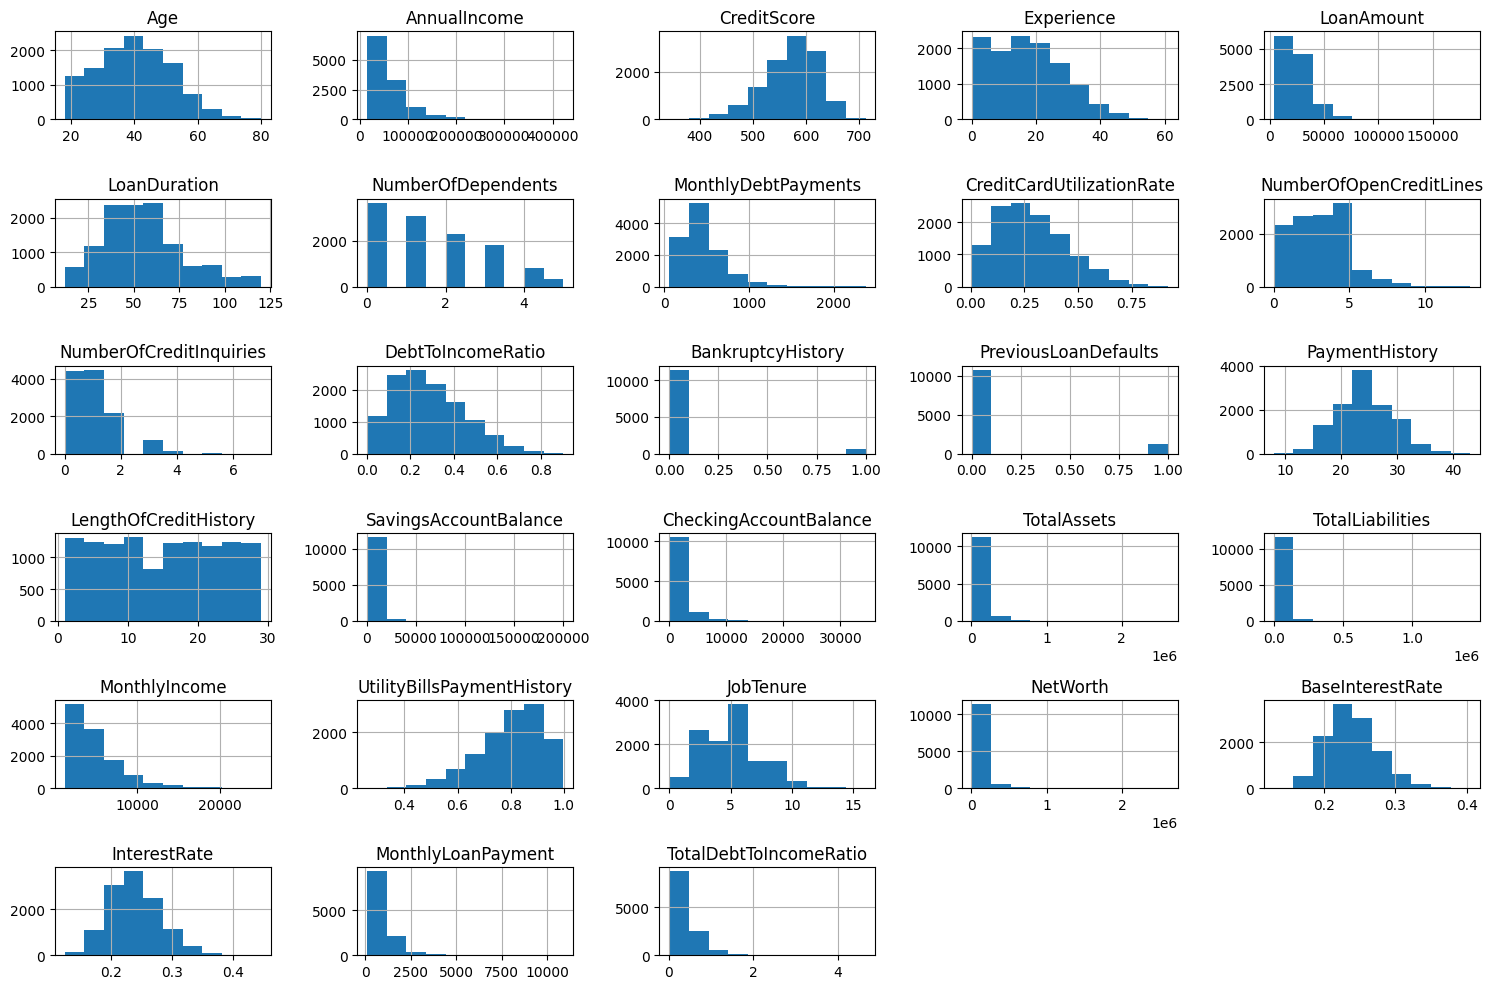

In [ ]:
import matplotlib.pyplot as plt

X_train[numeric_features].hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

In [ ]:
false_numerical_features = [
    'NumberOfDependents', 'BankruptcyHistory', 'PreviousLoanDefaults'
]

In [ ]:
def handle_outliers(data, features, method='clip'):
    '''
    This function does the following for each feature:
    1. Take 25% and 75% quantiles q_25 and q_75, that is points such that:
        - 25% data has values less than q_25
        - 75% data has values less than q_75
    2. Then, we take Intraquantale Range, the distance between q_25 and q_75
    3. After that, we set lower bound and upper bound of "normal values" of the feature
    '''

    data = data.copy()
    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        if method == 'clip':
            data[feature] = np.clip(data[feature], lower_bound, upper_bound)
        elif method == 'remove':
            data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]
    return data

Let's ponder a bit if we want to run the outlier pipeline on the non-normal features. Take `MonthlyIncome` as an example. It clearly has logarithmic scale, and running quantile-based outlier handling may be not too good.

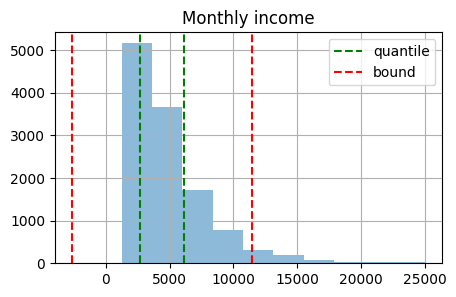

In [ ]:
monthly_income = X_train['MonthlyIncome']

q_25 = np.quantile(monthly_income, 0.25)
q_75 = np.quantile(monthly_income, 0.75)
IQR = q_75 - q_25
lower_bound = q_25 - 1.5 * IQR
upper_bound = q_75 + 1.5 * IQR

plt.title('Monthly income')
monthly_income.hist(figsize=(5, 3), alpha=0.5)
plt.axvline(x=q_25, color='green', linestyle='--', label='quantile')
plt.axvline(x=q_75, color='green', linestyle='--')
plt.axvline(x=lower_bound, color='red', linestyle='--', label='bound')
plt.axvline(x=upper_bound, color='red', linestyle='--')
plt.legend()

We have two ways of dealing with this: either use logarithm of the income or create additional feature `IncomeIsOutlier`. Let's try doing both.

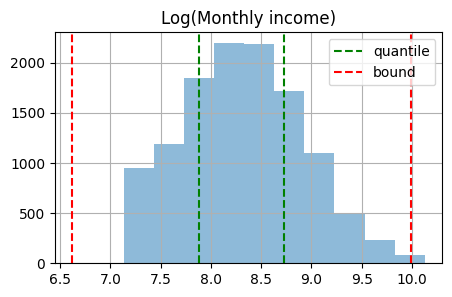

In [ ]:
monthly_income_log = np.log(X_train['MonthlyIncome'])

q_25 = np.quantile(monthly_income_log, 0.25)
q_75 = np.quantile(monthly_income_log, 0.75)
IQR = q_75 - q_25
lower_bound = q_25 - 1.5 * IQR
upper_bound = q_75 + 1.5 * IQR

plt.title('Log(Monthly income)')
monthly_income_log.hist(figsize=(5, 3), alpha=0.5)
plt.axvline(x=q_25, color='green', linestyle='--', label='quantile')
plt.axvline(x=q_75, color='green', linestyle='--')
plt.axvline(x=lower_bound, color='red', linestyle='--', label='bound')
plt.axvline(x=upper_bound, color='red', linestyle='--')
plt.legend()

So, to deal with logarithmic-scale features let's use the following function:

In [ ]:
log_features = [
    'AnnualIncome', 'MonthlyDebtPayments', 'CreditCardUtilizationRate',
    'CheckingAccountBalance', 'SavingsAccountBalance',
    'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'MonthlyLoanPayment'
    ]

for feature in log_features:
    X_train[feature] = np.log(X_train[feature])
    X_val[feature] = np.log(X_val[feature])
    X_test[feature] = np.log(X_test[feature])

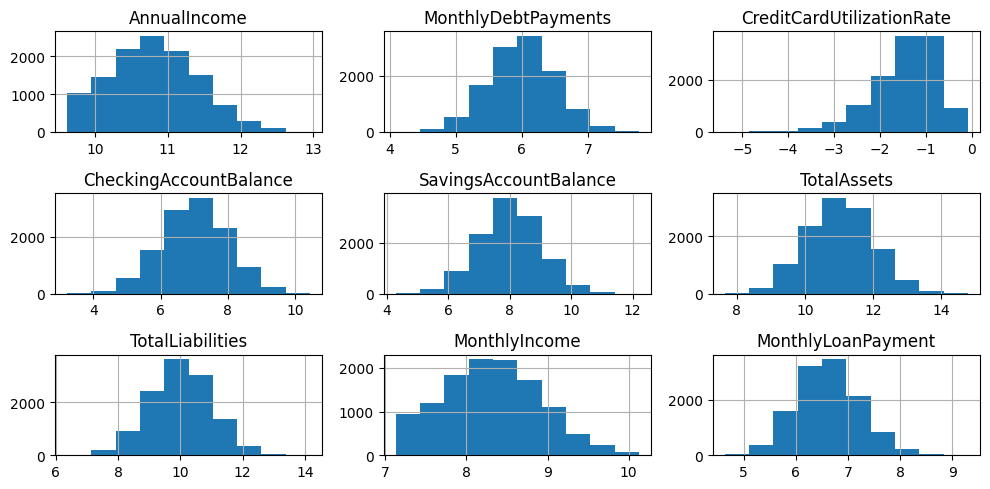

In [ ]:
import matplotlib.pyplot as plt

X_train[log_features].hist(figsize=(10, 5))
plt.tight_layout()
plt.show()

We also have several categorical features that pose as numerical. We'll discard them from the `numeric_features` list.

<Axes: title={'center': 'Bankruptcy History'}>

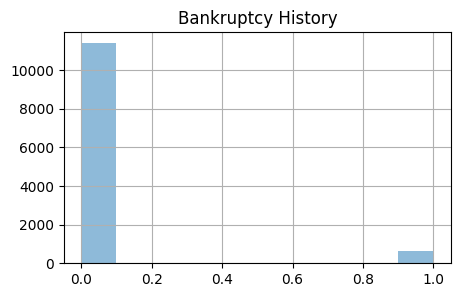

In [ ]:
bankrupcy_history = X_train['BankruptcyHistory']

plt.title('Bankruptcy History')
bankrupcy_history.hist(figsize=(5, 3), alpha=0.5)

In [ ]:
false_numerical_features = [
    'NumberOfDependents', 'BankruptcyHistory', 'PreviousLoanDefaults'
]

numeric_features = [
    feature for feature in numeric_features if feature not in false_numerical_features
]

### Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

## Categorical features

Let's discard application date, because it's probably not very useful and I don't want to deal with it.

In [ ]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist() + false_numerical_features
categorical_features.remove('ApplicationDate')
print("Categorical features:")
for feature in categorical_features:
    print('-', feature)

Categorical features:
- EmploymentStatus
- EducationLevel
- MaritalStatus
- HomeOwnershipStatus
- LoanPurpose
- NumberOfDependents
- BankruptcyHistory
- PreviousLoanDefaults


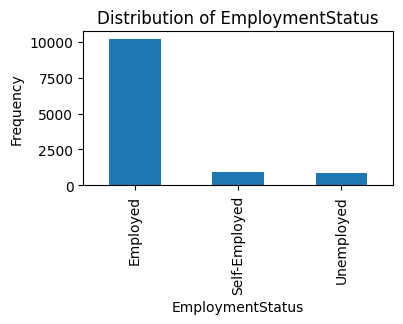

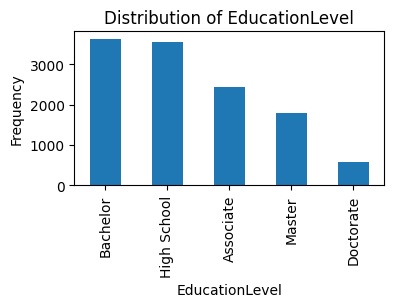

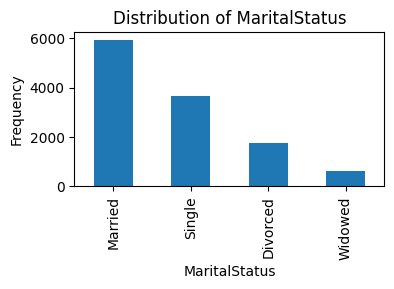

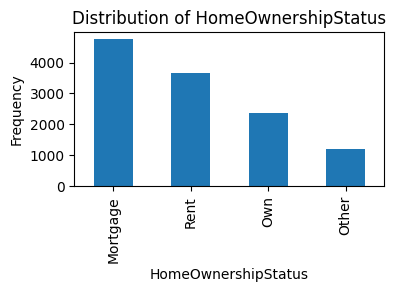

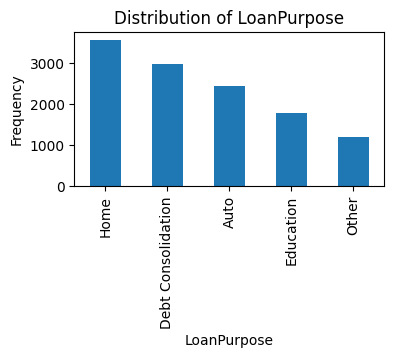

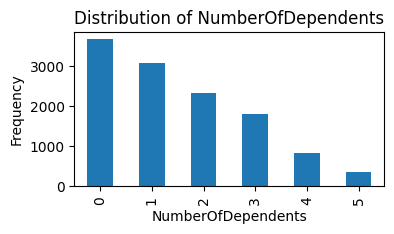

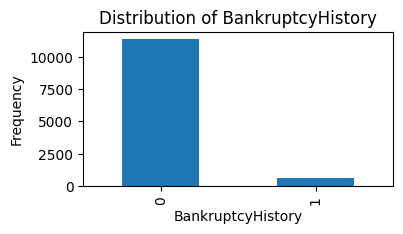

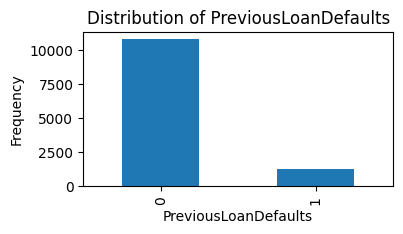

In [ ]:
for feature in categorical_features:
    plt.figure(figsize=(4, 2))
    X_train[feature].value_counts().plot(kind='bar')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

### One hot encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = [
    'EmploymentStatus', 'EducationLevel', 'MaritalStatus',
    'HomeOwnershipStatus', 'LoanPurpose', 'NumberOfDependents'
    ]

binary_features = ['BankruptcyHistory', 'PreviousLoanDefaults']

def one_hot_encode_data(df, numerical_features, categorical_features, binary_features):
    # Note that we drop the first of the dummy variables
    ohe_encoded = pd.get_dummies(df[categorical_features], drop_first=True)
    processed_data = pd.concat([df[numerical_features], df[binary_features], ohe_encoded], axis=1)
    return processed_data

print(f"Train shape before OHE: {X_train_full.shape}")

X_train = one_hot_encode_data(X_train, numeric_features, categorical_features, binary_features)
X_val = one_hot_encode_data(X_val, numeric_features, categorical_features, binary_features)
X_test = one_hot_encode_data(X_test, numeric_features, categorical_features, binary_features)

print(f"Train shape after OHE: {X_train.shape}")
print(f"Validation shape after OHE: {X_val.shape}")
print(f"Test shape after OHE: {X_test.shape}")

Train shape before OHE: (16000, 34)
Train shape after OHE: (12000, 44)
Validation shape after OHE: (4000, 44)
Test shape after OHE: (4000, 44)


## Training the model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, PrecisionRecallDisplay, f1_score, confusion_matrix, ConfusionMatrixDisplay

model = LogisticRegression(solver='liblinear', random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Model Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Model Metrics:
Accuracy: 0.9610
Precision: 0.9211
Recall: 0.9153
F1 Score: 0.9182


In [ ]:
for feature, coef in sorted(list(zip(X_train.columns, model.coef_[0])), key=lambda t: t[1]):
    print(f"{feature}: {coef}")

BankruptcyHistory: -4.917536714423793
InterestRate: -4.399229293681344
TotalDebtToIncomeRatio: -3.569887642182505
PreviousLoanDefaults: -3.4549142712027616
EmploymentStatus_Unemployed: -2.441836922479513
CreditScore: -1.7684070328899408
EducationLevel_High School: -1.4163087486517123
MonthlyLoanPayment: -1.3787879802055198
LoanAmount: -1.1207626705385578
HomeOwnershipStatus_Rent: -1.1132745657778835
HomeOwnershipStatus_Other: -0.8346254150751636
LoanDuration: -0.5897621029385778
MonthlyDebtPayments: -0.5596838037420351
LoanPurpose_Home: -0.20589603474682652
MaritalStatus_Widowed: -0.16530196769571046
LoanPurpose_Other: -0.09517112734714664
CreditCardUtilizationRate: -0.05639667962672687
TotalLiabilities: -0.05375326962864327
LoanPurpose_Debt Consolidation: -0.03696286856409372
NumberOfOpenCreditLines: -0.024225820941211725
NumberOfDependents: -0.020492397138929846
DebtToIncomeRatio: -0.0006971135750352931
UtilityBillsPaymentHistory: 0.00384792510823065
NumberOfCreditInquiries: 0.008858

The result is quite logical: bankrupsy history makes everything bad while Monthly Income improves the score.

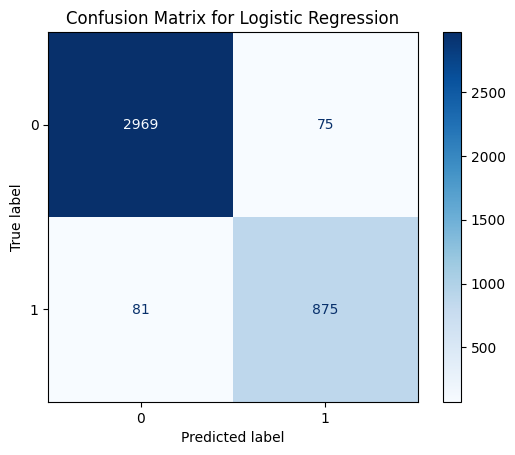

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

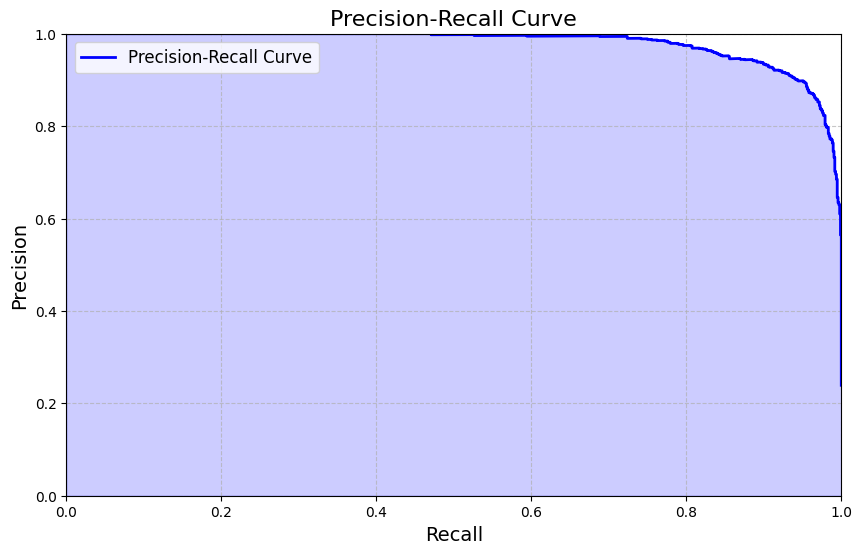

In [ ]:
y_scores = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', linewidth=2, label="Precision-Recall Curve")
plt.fill_between(recall, precision, alpha=0.2, color="blue")
plt.title("Precision-Recall Curve", fontsize=16)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc="best", fontsize=12)
plt.show()

In [ ]:
def find_precision_threshold(recall_target, precision, recall, thresholds):
    indices = np.where(recall >= recall_target)[0]
    if len(indices) == 0:
        raise ValueError(f"No recall values meet or exceed the target: {recall_target:.2f}")

    idx = indices[-1]

    precision_for_target = precision[idx]
    eventual_recall = recall[idx]
    threshold_for_target = thresholds[idx] if idx < len(thresholds) else None
    return precision_for_target, threshold_for_target, eventual_recall

precision_target = 0.95
recall_for_target, threshold_for_target, eventual_precision = find_precision_threshold(
    precision_target, precision, recall, thresholds
)

print(f"For precision >= {precision_target:.2f}:")
print(f"  Recall: {recall_for_target:.4f}")
print(f"  Threshold: {threshold_for_target:.4f}")
print(f"  Precision: {eventual_precision:.4f}")

For precision >= 0.95:
  Recall: 0.8982
  Threshold: 0.3637
  Precision: 0.9508


## Getting everything into a single pipeline

Accuracy: 0.962
Precision: 0.9240506329113924
Recall: 0.9163179916317992
F1 Score: 0.9201680672268907


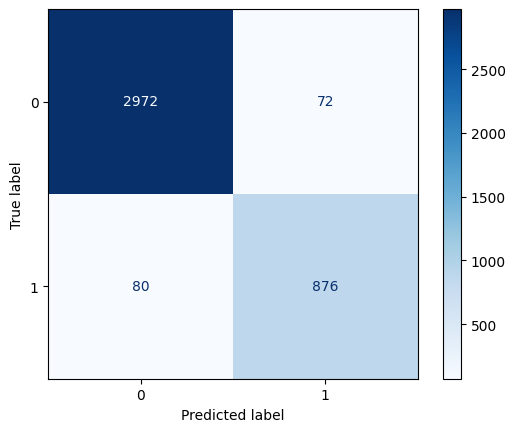

In [ ]:
# prompt: Make the data preprocessing and training process above into one sklearn pipeline

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Load the data (assuming it's already downloaded)
loan_data = pd.read_csv('Loan.csv')

# Define features and target
X = loan_data.drop(columns=['LoanApproved', 'RiskScore', 'ApplicationDate'])
y = loan_data['LoanApproved']

# Split the data
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

# Define feature types
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns

log_features = [
    'AnnualIncome', 'MonthlyDebtPayments', 'CreditCardUtilizationRate',
    'CheckingAccountBalance', 'SavingsAccountBalance',
    'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'MonthlyLoanPayment'
    ]

other_numeric_features = [feature for feature in numeric_features if not feature in log_features]

categorical_features = [
    'EmploymentStatus', 'EducationLevel', 'MaritalStatus',
    'HomeOwnershipStatus', 'LoanPurpose', 'NumberOfDependents'
    ]

binary_features = ['BankruptcyHistory', 'PreviousLoanDefaults']

# Create the preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

log_numeric_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log, validate=True)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, other_numeric_features),
        ('num_log', log_numeric_transformer, log_features),
        ('cat', categorical_transformer, categorical_features),
    ], remainder='passthrough')

# Create the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=0))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.show()

# Part 2. Suddenly, three theoretical questions

(a) Imagine that my binary classifier got recall 0.8 on a dataset with balanced classes (same number of class 0 and class 1 objects). What could be its minimal and maximal precision?

(b) Imagine that my binary classifier got F1-score 0.75. What could be its minimal and maximal precision and recall? What could be its minimal and maximal accuracy? Here, the dataset is not necessary balanced.

(c) If my binary classifier's AUC ROC is 0.8, can its accuracy be 0.5? Can it be 0.1?

Please, don't just ask ChatGPT, and if you do, check its reasoning!

## Solutions

(a) Let $x$ be the number of class 1 objects. Than recall 0.8 means that 80% of them are classified as class 1 (that's TN) and 20% as class 0 (that's FN). Let's populate the magic table:

|                | Classified as class 1 | Classified as class 0 |
| :---------------- | :------: | ----: |
| Class 1        |   $0.8x$   | $0.2x$ |
| Class 0           |   ???   | ??? |

Since the dataset is balanced, Class 0 also contains $x$ elements. So, we get some

|                | Classified as class 1 | Classified as class 0 |
| :---------------- | :------: | ----: |
| Class 1        |   $0.8x$   | $0.2x$ |
| Class 0           |   $\alpha x$   | $(1 - \alpha)x$ |

where $0\leqslant \alpha \leqslant 1$ (and that's all we know about $\alpha$. Now, the precision is
$$\frac{0.8x}{0.8x + \alpha x} = \frac{0.8}{0.8 + \alpha},\quad 0\leqslant\alpha\leqslant1$$

Now we can either do some math:
$$0\leqslant\alpha\leqslant1 \Rightarrow 0.8\leqslant 0.8 + \alpha\leqslant 1.8 \Rightarrow$$

$$\Rightarrow\frac1{1.8}\leqslant\frac1{0.8 + \alpha} \leqslant \frac1{0.8}
\Rightarrow \frac49=\frac{0.8}{1.8}\leqslant\frac{0.8}{0.8 + \alpha} \leqslant \frac{0.8}{0.8} = 1$$

Or we can plot this function:

(0.0, 1.0)

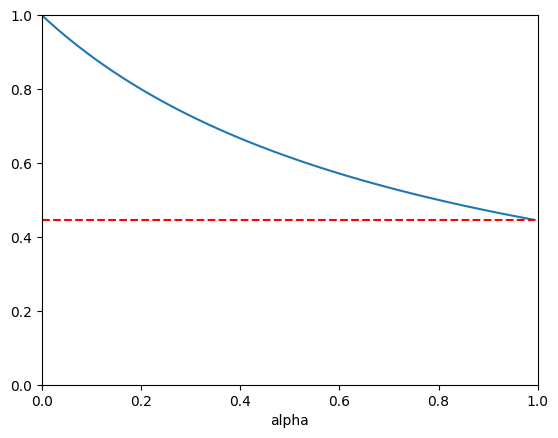

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

xx = np.arange(0, 1, 0.01)
yy = 0.8 / (0.8 + xx)

plt.plot(xx, yy)
plt.axhline(y=4/9, color='r', linestyle='--')
plt.xlabel('alpha')
plt.xlim([0,1])
plt.ylim([0,1])

(b) We know that

$$0.75 = \text{F1} = \frac{2\cdot\text{precision}\cdot\text{recall}}{\text{precision} + \text{recall}} = \frac{2}{\frac1{\text{precision}} + \frac1{\text{recall}}}$$

Now, I would express

$$\frac2{\text{F1}} = \frac1{\text{precision}} + \frac1{\text{recall}}$$

$$\text{precision} = \frac1{\frac2{\text{F1}} - \frac1{\text{recall}}} = \frac{\text{recall}}{\frac83\cdot\text{recall} - 1}$$

and plot this function:

(0.0, 1.0)

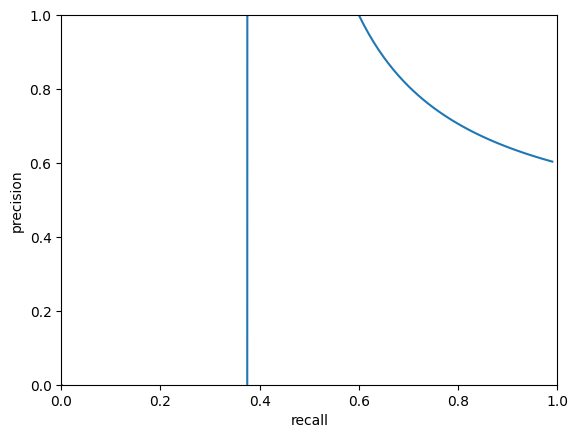

In [ ]:
xx = np.arange(0, 1, 0.01)
yy = xx / (8/3*xx - 1)

plt.plot(xx, yy)
# plt.axhline(y=4/9, color='r', linestyle='--')
plt.xlabel('recall')
plt.ylabel('precision')
plt.xlim([0,1])
plt.ylim([0,1])

The vertical line is the asymptote, and we can clearly see that for max recall = 1 we have min precision $=\frac{1}{\frac83-1}=0.6$. The situation is clearly symmetric.

(c) AUC ROC = 0.8 means that among all pairs (object of class 0, object of class 1) 80% are ordered correctly by out logits, i.e. class 1 object has higher logits.

For example, this is true if the logits order the data in the following way (from top to bottom):
* 80% of class 1 objects
* All class 0 objects
* 20% of class 1 objects.

Indeed, 80% pairs (object of class 0, object of class 1) will have the second element from the top part.

Now, we'll leverage the fact that we can set
* threshold and
* class proportions

however we like.

Let's set threshold = 0 (thus all objects are classified as class 1).

Then, if classes are balanced, the accuracy will be exactly 0.5.

At the same time, if class 1 / class 0 ratio is 0.1, we'll get accuracy 0.1.

# Part 3. Your LLM-powered ML assistant

Preprocessign data is boring and feature engineering may be tricky, so I challenge you to create an LLM-powered agent to do this for you!

I suggest the following operational framework for this agent:

1. In the initial message, the user tells the agent:

  - In which *.csv file the data is.
  - Basic information about the features and the target: feature types, their meaning. Something you yourself would like to get from the dataset creator before getting to the task :)

2. The LLM creates and launches a Python script `classify.py` that loads the dataset, transforms its features in an appropriate way, does train-test split, trains the model on train and saves classification metrics on test to `results.csv`. As responce to the user, the LLM also reports the metrics.

  The agent also logs the code it produced and the metrics it obtained.

3. Given the metrics, the user can either answer that it's ok or that the agent could do it better. In the latter case, the agent revises previously generated code and metrics and creates a new data processing & feature engineering pipeline. If the new pipeline gets higher F1 score (you can choose a different metric), the agent reports them to the user, otherwise the agent does `n_trials` more attempts at increasing F1 score and, if this fails, reports a failure.

4. A user can also initiate a conversation about a new dataset. In this case, the agent empties its logs.

**Why this is exciting.** Not only because you can (probably) forget about feature engineering :) Compared to the previous week's agents, this one has a natural feedback loop and memory. So, it is able to learn on its experience in a way. Its memory is still ineficcient (we just store everything), but we'll address this issue on Week 5.

For simplicity, let's deal only with binary classification tasks.

**Your task.** You'll need to code this agent. I've made some boilerplate code for you, and for the agent as well. The agent's boilerplate code is in the `boilerplate.py` file. I felt it could help with keeping things more predictable. But feel free to try without it.

Experiment with the Australian weather data from the practice session. What quality will the agent be able to achieve? Will you get any interesting insights from the agent? Will your agent ever try cheating on you and reporting false results?

In [ ]:
%%writefile boilerplate.py
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
import pandas as pd


df = pd.read_csv('dataset.csv') # Put the right file name
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
X = df.drop(columns=['RainTomorrow', 'Date'])
y = df['RainTomorrow']

# Please don't change the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Your feature preprocessing goes here, dear LLM
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
for feature in numeric_features:
    median_value = X_train[feature].median()
    X_train[feature] = X_train[feature].fillna(median_value)
    X_test[feature] = X_test[feature].fillna(median_value)
categorical_features = X_train.select_dtypes(include=['object']).columns
for feature in categorical_features:
    most_frequent = X_train[feature].mode()[0]
    X_train[feature] = X_train[feature].fillna(most_frequent)
    X_test[feature] = X_test[feature].fillna(most_frequent)

# You should only use the LogisticRegression() model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:,1]

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_scores)

# Don't change the following code
with open('results.csv', 'w') as f:
    f.write(f'f1_score:{f1}\n')
    f.write(f'auc_roc_score:{roc_auc}')

Writing boilerplate.py


Feel free to use the following template to create your agent:

In [ ]:
import openai
import json
import subprocess
import os
from typing import List, Dict, Any
import shlex
from openai import OpenAI

class MLCompanionAgent:
    def __init__(self, api_key: str, model='gpt-4o-mini', n_trials=5):
        # Right now only OpenAI API is supported here, but feel free to use anything else you like
        self.model = model
        self.client = OpenAI(api_key=api_key)
        self.attempt_history = []
        self.ongoing_chat = False
        self.initial_users_prompt = None
        self.n_trials = n_trials

        # Feel free to add more tools if you need them
        self.tools = [
            {
                "type": "function",
                "function": {
                    "name": "start_anew",
                    "description": "Start the dialog anew: forget the previous communication and be ready to explore another dataset",
                    "parameters": {
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "execute_python",
                    "description": "Execute a Python script file",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "script_path": {
                                "type": "string",
                                "description": "Path to the Python script to execute"
                            }
                        },
                        "required": ["script_path"]
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "read_file",
                    "description": "Read contents of a file",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "file_path": {
                                "type": "string",
                                "description": "Path to the file to read"
                            }
                        },
                        "required": ["file_path"]
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "write_file",
                    "description": "Write content to a file",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "file_path": {
                                "type": "string",
                                "description": "Path to the file to write"
                            },
                            "content": {
                                "type": "string",
                                "description": "Content to write to the file"
                            },
                            "mode": {
                                "type": "string",
                                "description": "Write mode: 'w' for overwrite, 'a' for append",
                                "enum": ["w", "a"],
                                "default": "w"
                            }
                        },
                        "required": ["file_path", "content"]
                    }
                }
            }
        ]

        # Set up system message for the ML companion
        self.system_message = ...# <EXPLAIN TO THE AGENT ITS JOB HERE>

    def start_anew(self):
        self.attempt_history = []
        self.ongoing_chat = False
        self.initial_users_prompt = None
        return {
            "success": True,
            "message": "Let me know which new dataset we are going to explore next!"
        }

    def execute_python(self, script_path: str) -> Dict[str, Any]:
        """Execute a Python script and return its output."""
        try:
            result = subprocess.run(
                ['python', script_path],
                capture_output=True,
                text=True,
                shell=False
            )
            return {
                "success": True,
                "stdout": result.stdout,
                "stderr": result.stderr,
                "return_code": result.returncode
            }
        except Exception as e:
            return {
                "success": False,
                "error": str(e)
            }

    def read_file(self, file_path: str) -> Dict[str, Any]:
        """Read a file and return its contents."""
        try:
            with open(file_path, 'r') as f:
                content = f.read()
            return {
                "success": True,
                "content": content
            }
        except Exception as e:
            return {
                "success": False,
                "error": str(e)
            }

    def write_file(self, file_path: str, content: str, mode: str = 'w') -> Dict[str, Any]:
        """Write content to a file."""
        try:
            with open(file_path, mode) as f:
                f.write(content)
            return {
                "success": True,
                "message": f"Successfully wrote to {file_path}",
                "bytes_written": len(content)
            }
        except Exception as e:
            return {
                "success": False,
                "error": str(e)
            }

    def process_tool_call(self, tool_call) -> Dict[str, Any]:
        """Process a tool call from the API response."""
        function_name = tool_call.function.name
        function_args = json.loads(tool_call.function.arguments)

        if function_name == "start_anew":
            return self.start_anew()
        if function_name == "execute_python":
            return self.execute_python(function_args["script_path"])
        elif function_name == "read_file":
            return self.read_file(function_args["file_path"])
        elif function_name == "write_file":
            mode = function_args.get("mode", "w")
            return self.write_file(
                function_args["file_path"],
                function_args["content"],
                mode
            )
        else:
            return {"success": False, "error": f"Unknown function: {function_name}"}

    def chat(self, user_message: str) -> str:
        """Process user input and return assistant response."""
        messages = [
            {"role": "system", "content": self.system_message},
            {"role": "user", "content": user_message}
        ]

        try:
            completion = self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                tools=self.tools,
                tool_choice="auto"
            )

            message = completion.choices[0].message

            while message.tool_calls:
                messages.append(message)

                for tool_call in message.tool_calls:
                    result = self.process_tool_call(tool_call)
                    messages.append({
                        "role": "tool",
                        "tool_call_id": tool_call.id,
                        "content": json.dumps(result)
                    })

                completion = self.client.chat.completions.create(
                    model=self.model,
                    messages=messages,
                    tools=self.tools,
                    tool_choice="auto"
                )
                message = completion.choices[0].message

            return {
                "response": message.content,
                "message_log": messages
            }

        except Exception as e:
            return f"Error: {str(e)}"

    def handle_request(self, user_message: str) -> str:
        """
        Main method to handle user requests.
        It defines the overall agentic framework and forms prompts
          that are passed to the chat method.
        """

        """
        <THIS FUNCTION IS FOR YOU TO IMPLEMENT>

        What you'll need to do here:

        1. Distinguish between the first request about the dataset
           and the subsequent "You can do better!" requests.
           I suggest using the self.ongoing_chat variable for that.

        2. For the initial call, just push the user's query into chat()

        3. For the subsequent calls, you'll need to add context to the query.
           We suggest putting the following things into the context:
           - User's initial query containing the dataset file name and feature description.
           - Code and metrics from pervious attemts (keep them in self.attempt_history).

        4.  Also, for the subsequent calls we suggest making several trials to optimize F1 score (or another metric you choose):
          - If F1 score is larger than the previous best F1 score, return the result to the user.
          - Otherwise, attempt one more time, and again,
            until the agent gets you better F1 score or reaches n_trials
        """

        # <YOUR CODE HERE>



That's how we could call the agent. But don't forget to put the *.csv file containing the dataset into the same folder before running the next cell.

In [ ]:
# Initialize agent with your API key
agent = MLCompanionAgent(api_key=os.environ.get("OPENAI_API_KEY"))

initial_message = """
The data is in the weatherAUS.csv
The data is described by the following features:
 0   Date           in YYYY-MM-DD format
 1   Location       a string, the name of the location
 2   MinTemp        numeric, the minimum temperature in degrees Celsius
 3   MaxTemp        numeric, the minimum temperature in degrees Celsius
 4   Rainfall       numeric, the amount of rainfall
 5   Evaporation    numeric
 6   Sunshine       numeric
 7   WindGustDir    a string, may be N, NW, NNW etc
 8   WindGustSpeed  numeric
 9   WindDir9am     a string, may be N, NW, NNW etc
 10  WindDir3pm     a string, may be N, NW, NNW etc
 11  WindSpeed9am   numeric
 12  WindSpeed3pm   numeric
 13  Humidity9am    numeric
 14  Humidity3pm    numeric
 15  Pressure9am    numeric
 16  Pressure3pm    numeric
 17  Cloud9am       numeric
 18  Cloud3pm       numeric
 19  Temp9am        numeric
 20  Temp3pm        numeric
 21  RainToday      Yes/No.
 22  RainTomorrow   Yes/No. This is the target
"""

response = agent.handle_request(initial_message)
response

In [ ]:
response = agent.handle_request("You can do better!")
response

## Solution

In [ ]:
!gdown 1oDLRJgsOl_s_5FTbmL0XASp0-glW697E # download weatherAUS.csv

Downloading...
From: https://drive.google.com/uc?id=1oDLRJgsOl_s_5FTbmL0XASp0-glW697E
To: /content/weatherAUS.csv
100% 14.1M/14.1M [00:00<00:00, 27.9MB/s]


In [ ]:
!pip install -q openai

In [ ]:
import os

with open("openai_api_key", "r") as file:
    openai_api_key = file.read().strip()

os.environ["OPENAI_API_KEY"] = openai_api_key

with open("nebius_api_key", "r") as file:
    nebius_api_key = file.read().strip()

os.environ["NEBIUS_API_KEY"] = nebius_api_key

In [ ]:
import openai
import json
import subprocess
import os
from typing import List, Dict, Any
import shlex
from openai import OpenAI

class MLCompanionAgent:
    def __init__(self, api_key: str, model='gpt-4o-mini'):
        # Right now only OpenAI API is supported here, but feel free to use anything else you like
        self.model = model
        self.client = OpenAI(api_key=api_key)
        self.attempt_history = []
        self.ongoing_chat = False
        self.initial_users_prompt = None

        self.tools = [
            {
                "type": "function",
                "function": {
                    "name": "start_anew",
                    "description": "Start the dialog anew: forget the previous communication and be ready to explore another dataset",
                    "parameters": {
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "execute_python",
                    "description": "Execute a Python script file",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "script_path": {
                                "type": "string",
                                "description": "Path to the Python script to execute"
                            }
                        },
                        "required": ["script_path"]
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "read_file",
                    "description": "Read contents of a file",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "file_path": {
                                "type": "string",
                                "description": "Path to the file to read"
                            }
                        },
                        "required": ["file_path"]
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "write_file",
                    "description": "Write content to a file",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "file_path": {
                                "type": "string",
                                "description": "Path to the file to write"
                            },
                            "content": {
                                "type": "string",
                                "description": "Content to write to the file"
                            },
                            "mode": {
                                "type": "string",
                                "description": "Write mode: 'w' for overwrite, 'a' for append",
                                "enum": ["w", "a"],
                                "default": "w"
                            }
                        },
                        "required": ["file_path", "content"]
                    }
                }
            }
        ]

        # Set up system message for the ML companion
        self.system_message = """You are an ML expert assistant that helps improve binary classification models. You will:
1. Read the boilerplate code in boilerplate.py and understand the basic pipeline
2. Read the data description provided by the user
3. Suggest and implement preprocessing steps including:
   - Handling categorical variables
   - Feature normalization
   - Feature engineering
4. Modify the boilerplate code to include these improvements and save it to script.py
5. Execute the code in script.py and analyze results
6. Don't forget to write the metrics (f1 score and roc auc) ON TEST DATA to results.csv
7. If asked to improve, analyze previous attempts and suggest new approaches

NEVER change the data file or the boilerplate.py file.
Always write complete, runnable Python code. Track your attempts and avoid repeating unsuccessful approaches."""

    def start_anew(self):
        self.attempt_history = []
        self.ongoing_chat = False
        self.initial_users_prompt = None
        return {
            "success": True,
            "message": "Let me know which new dataset we are going to explore next!"
        }

    def execute_python(self, script_path: str) -> Dict[str, Any]:
        """Execute a Python script and return its output."""
        try:
            result = subprocess.run(
                ['python', script_path],
                capture_output=True,
                text=True,
                shell=False
            )
            return {
                "success": True,
                "stdout": result.stdout,
                "stderr": result.stderr,
                "return_code": result.returncode
            }
        except Exception as e:
            return {
                "success": False,
                "error": str(e)
            }

    def read_file(self, file_path: str) -> Dict[str, Any]:
        """Read a file and return its contents."""
        try:
            with open(file_path, 'r') as f:
                content = f.read()
            return {
                "success": True,
                "content": content
            }
        except Exception as e:
            return {
                "success": False,
                "error": str(e)
            }

    def write_file(self, file_path: str, content: str, mode: str = 'w') -> Dict[str, Any]:
        """Write content to a file."""
        try:
            with open(file_path, mode) as f:
                f.write(content)
            return {
                "success": True,
                "message": f"Successfully wrote to {file_path}",
                "bytes_written": len(content)
            }
        except Exception as e:
            return {
                "success": False,
                "error": str(e)
            }

    def process_tool_call(self, tool_call) -> Dict[str, Any]:
        """Process a tool call from the API response."""
        function_name = tool_call.function.name
        function_args = json.loads(tool_call.function.arguments)

        if function_name == "start_anew":
            return self.start_anew()
        if function_name == "execute_python":
            return self.execute_python(function_args["script_path"])
        elif function_name == "read_file":
            return self.read_file(function_args["file_path"])
        elif function_name == "write_file":
            mode = function_args.get("mode", "w")
            return self.write_file(
                function_args["file_path"],
                function_args["content"],
                mode
            )
        else:
            return {"success": False, "error": f"Unknown function: {function_name}"}

    def chat(self, user_message: str) -> str:
        """Process user input and return assistant response."""
        messages = [
            {"role": "system", "content": self.system_message},
            {"role": "user", "content": user_message}
        ]

        try:
            completion = self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                tools=self.tools,
                tool_choice="auto"
            )

            message = completion.choices[0].message

            while message.tool_calls:
                messages.append(message)

                for tool_call in message.tool_calls:
                    result = self.process_tool_call(tool_call)
                    messages.append({
                        "role": "tool",
                        "tool_call_id": tool_call.id,
                        "content": json.dumps(result)
                    })

                completion = self.client.chat.completions.create(
                    model=self.model,
                    messages=messages,
                    tools=self.tools,
                    tool_choice="auto"
                )
                message = completion.choices[0].message

            return {
                "response": message.content,
                "message_log": messages
            }

        except Exception as e:
            return f"Error: {str(e)}"

    def handle_request(self, user_message: str) -> str:
        """Main method to handle user requests."""
        # Add context about previous attempts if they exist

        if self.ongoing_chat:
            context = "\n DATASET DESCRIPTION:\n"
            context += self.initial_users_prompt
            context += "\nPREVIOUS ATTEMPTS AND RESULTS:\n"
            context += json.dumps(self.attempt_history, indent=2)
            user_message += context
            user_message += """\nNow, create the new, better version of the pipeline to increase metrics.
            If you do better than before, I'll tip you 200$."""
        else:
            self.ongoing_chat = True
            self.initial_users_prompt = user_message

        response = self.chat(user_message)

        # Read the latest results if they exist
        results = self.read_file('results.csv')
        code = self.read_file('script.py')

        if results['success']:
            self.attempt_history.append({
                'code': code['content'],
                'results': results['content']
            })

        return response



In [ ]:
# Initialize agent with your API key
agent = MLCompanionAgent(api_key=os.environ.get("OPENAI_API_KEY"))

initial_message = """
The data is in the weatherAUS.csv
The data is described by the following features:
 0   Date           in YYYY-MM-DD format
 1   Location       a string, the name of the location
 2   MinTemp        numeric, the minimum temperature in degrees Celsius
 3   MaxTemp        numeric, the minimum temperature in degrees Celsius
 4   Rainfall       numeric, the amount of rainfall
 5   Evaporation    numeric
 6   Sunshine       numeric
 7   WindGustDir    a string, may be N, NW, NNW etc
 8   WindGustSpeed  numeric
 9   WindDir9am     a string, may be N, NW, NNW etc
 10  WindDir3pm     a string, may be N, NW, NNW etc
 11  WindSpeed9am   numeric
 12  WindSpeed3pm   numeric
 13  Humidity9am    numeric
 14  Humidity3pm    numeric
 15  Pressure9am    numeric
 16  Pressure3pm    numeric
 17  Cloud9am       numeric
 18  Cloud3pm       numeric
 19  Temp9am        numeric
 20  Temp3pm        numeric
 21  RainToday      Yes/No.
 22  RainTomorrow   Yes/No. This is the target
"""

response = agent.handle_request(initial_message)
response

{'response': 'The model has been successfully executed, and the results are as follows:\n\n- **F1 Score**: 0.5995\n- **ROC AUC Score**: 0.8688\n\nThese metrics indicate a decent performance for the binary classification task. If you would like to further improve the model or explore new approaches, please let me know!',
 'message_log': [{'role': 'system',
   'content': "You are an ML expert assistant that helps improve binary classification models. You will:\n1. Read the boilerplate code in boilerplate.py and understand the basic pipeline\n2. Read the data description provided by the user\n3. Suggest and implement preprocessing steps including:\n   - Handling categorical variables\n   - Feature normalization\n   - Feature engineering\n4. Modify the boilerplate code to include these improvements and save it to script.py\n5. Execute the code in script.py and analyze results\n6. Don't forget to write the metrics (f1 score and roc auc) ON TEST DATA to results.csv\n7. If asked to improve, a

I want to check the code and its outputs, adding calculation of the F1 score:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd


df = pd.read_csv('weatherAUS.csv')
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# Dropping rows where RainTomorrow is NaN

df.dropna(subset=['RainTomorrow'], inplace=True)

# Feature Engineering

df['TempRange'] = df['MaxTemp'] - df['MinTemp']
df['WindSpeedDiff'] = df['WindSpeed3pm'] - df['WindSpeed9am']
df['HumidityDiff'] = df['Humidity3pm'] - df['Humidity9am']

# Fill NaN values after feature engineering
numeric_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'TempRange', 'WindSpeedDiff', 'HumidityDiff']
for feature in numeric_features:
    median_value = df[feature].median()
    df[feature] = df[feature].fillna(median_value)

# Dropping original features that are now redundant
X = df.drop(columns=['RainTomorrow', 'Date'])
y = df['RainTomorrow']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numeric features
categorical_features = X_train.select_dtypes(include=['object']).columns
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns

# Preprocessing using ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit and transform the training data
X_train = preprocessor.fit_transform(X_train)
# Transform the test data
X_test = preprocessor.transform(X_test)

# Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:,1]

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_scores)

# Write results to CSV
print(f'f1_score:{f1}\n')
print(f'auc_roc_score:{roc_auc}')

f1_score:0.5995230232984774

auc_roc_score:0.8687687449930747


In [ ]:
response = agent.handle_request("You did a great job! But you can do better. Create a new feature engineering strategy and a new model.")
response

{'response': "The new model with enhanced feature engineering yielded the following results:\n\n- **F1 Score:** 0.6012\n- **ROC AUC Score:** 0.8689\n\n### Analysis of Improvements:\n- We've improved the F1 score slightly compared to the previous score of 0.5995.\n- The ROC AUC score remains quite stable, indicating that the model is reliably distinguishing between classes, albeit with minor improvements overall.\n\n### Next Steps:\nIf you're seeking further improvements beyond these results, I could explore:\n- Hyperparameter tuning for the Logistic Regression model.\n- Incorporating Cross-Validation to better estimate model performance.\n- Investigating additional feature transformations or polynomial features.\n\nWould you like me to pursue any of these directions?",
 'message_log': [{'role': 'system',
   'content': "You are an ML expert assistant that helps improve binary classification models. You will:\n1. Read the boilerplate code in boilerplate.py and understand the basic pipeli

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


df = pd.read_csv('weatherAUS.csv')
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# Dropping rows where RainTomorrow is NaN

df.dropna(subset=['RainTomorrow'], inplace=True)

# Feature Engineering

df['AverageTemp'] = (df['MaxTemp'] + df['MinTemp']) / 2

df['TotalWindSpeed'] = df['WindSpeed9am'] + df['WindSpeed3pm']
df['HumidityDiff'] = df['Humidity3pm'] - df['Humidity9am']
df['TempDeviation'] = df['Temp9am'] - df['AverageTemp']

df.drop(columns=['Date'], inplace=True)  # Dropping the date column

# Fill NaN values
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
for feature in numeric_features:
    median_value = df[feature].median()
    df[feature].fillna(median_value, inplace=True)

# Prepare X and y
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numeric features
categorical_features = X_train.select_dtypes(include=['object']).columns
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns

# Preprocessing using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit and transform the training data
X_train = preprocessor.fit_transform(X_train)
# Transform the test data
X_test = preprocessor.transform(X_test)

# Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:,1]

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_scores)

# Write results to CSV
print(f'f1_score:{f1}\n')
print(f'auc_roc_score:{roc_auc}')

<ipython-input-36-45ccd823f877>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(median_value, inplace=True)


f1_score:0.6012090126396776

auc_roc_score:0.8688577879252131
